In [2]:
# 1. Importar librerías base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Configuración visual para que los gráficos se vean profesionales
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# 2. Montar Google Drive
drive.mount('/content/drive')

# 3. Cargar los datos (Ajusta la ruta según dónde guardaste el archivo en tu Drive)
# Ejemplo: si lo guardaste en la carpeta Portafolio_NovaRetail
ruta_archivo = '/content/drive/MyDrive/800 Portafolio/0002_Portafolio_NovaRetail/ventas_novaretail_3anios.csv'

print("Cargando el dataset, esto puede tomar unos segundos...")
df = pd.read_csv(ruta_archivo)

# Convertir la columna Fecha a formato Datetime (crucial para series de tiempo)
df['Fecha'] = pd.to_datetime(df['Fecha'])

print(f"Dataset cargado con {df.shape[0]:,} filas y {df.shape[1]} columnas.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cargando el dataset, esto puede tomar unos segundos...
Dataset cargado con 4,599,000 filas y 12 columnas.


In [3]:
print("--- RESUMEN DE CALIDAD DE DATOS ---")
# Revisar nulos
nulos = df.isnull().sum()
print(f"Valores nulos por columna:\n{nulos[nulos > 0]}\n")

# Ordenar los datos cronológicamente (Regla de oro en pronóstico de demanda)
df = df.sort_values(by=['Fecha', 'ID_Tienda', 'ID_Producto']).reset_index(drop=True)

# Veamos el periodo de tiempo exacto
fecha_min = df['Fecha'].min().date()
fecha_max = df['Fecha'].max().date()
print(f"Datos desde {fecha_min} hasta {fecha_max}")

--- RESUMEN DE CALIDAD DE DATOS ---
Valores nulos por columna:
Series([], dtype: int64)

Datos desde 2021-01-01 hasta 2023-12-31


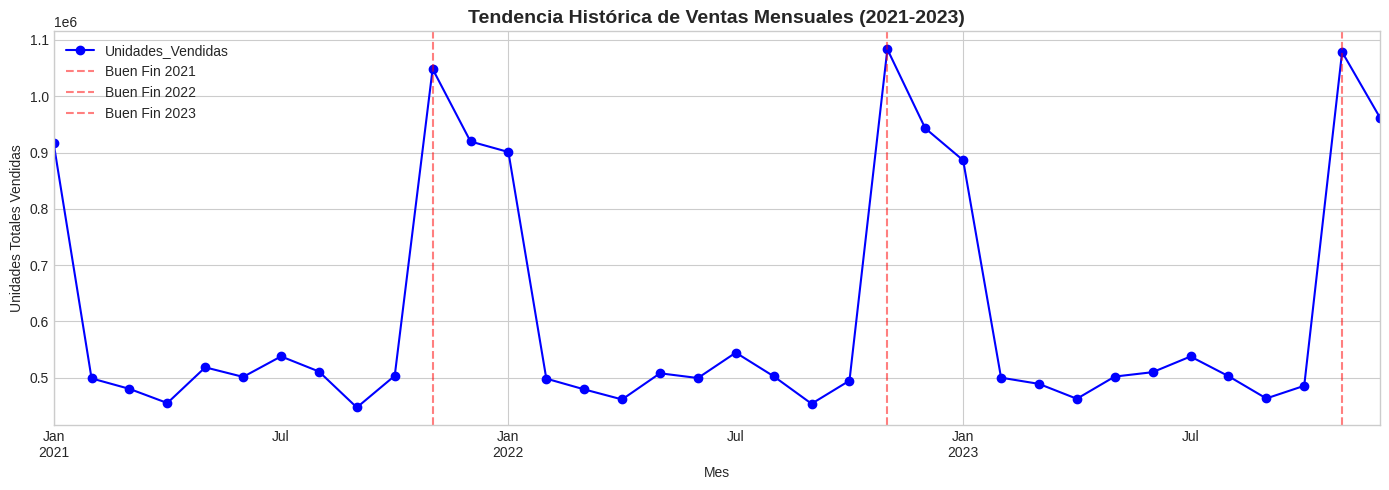

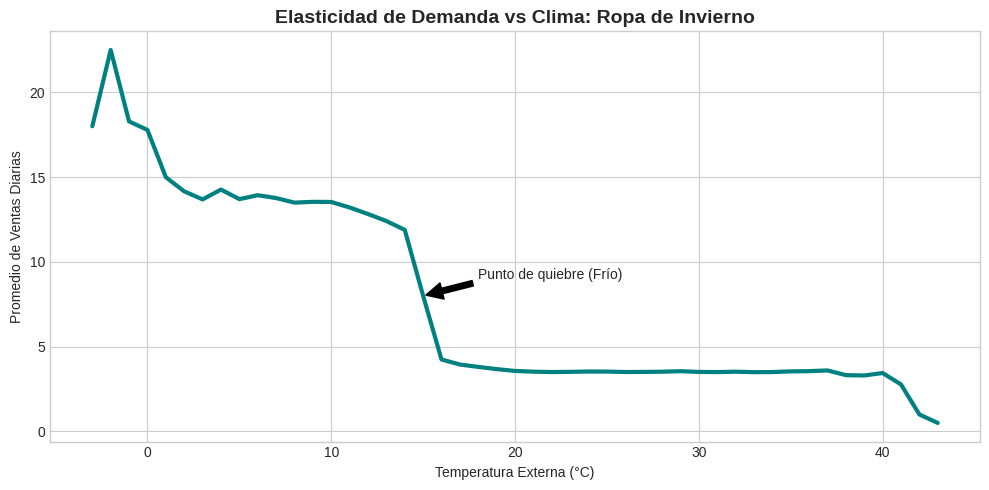

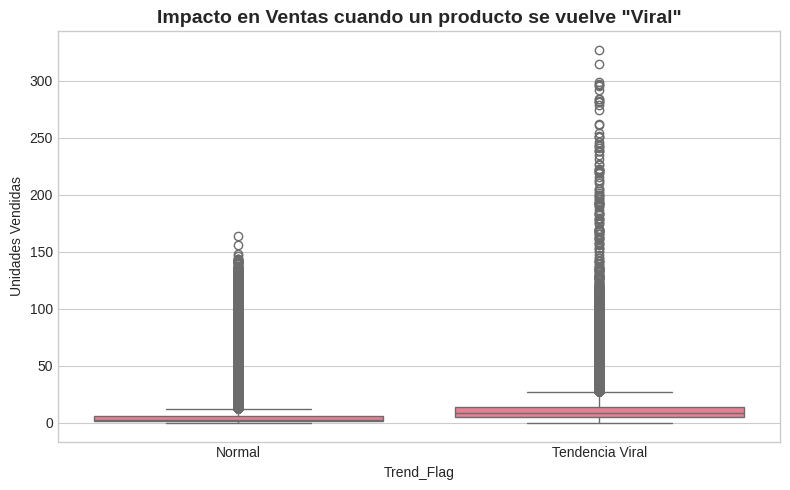

In [4]:
# Gráfico 1: Estacionalidad macro (Ventas totales por mes)
plt.figure(figsize=(14, 5))
ventas_mensuales = df.groupby(df['Fecha'].dt.to_period('M'))['Unidades_Vendidas'].sum()
ventas_mensuales.plot(kind='line', marker='o', color='b')
plt.title('Tendencia Histórica de Ventas Mensuales (2021-2023)', fontsize=14, fontweight='bold')
plt.ylabel('Unidades Totales Vendidas')
plt.xlabel('Mes')
plt.axvline(x='2021-11', color='r', linestyle='--', alpha=0.5, label='Buen Fin 2021')
plt.axvline(x='2022-11', color='r', linestyle='--', alpha=0.5, label='Buen Fin 2022')
plt.axvline(x='2023-11', color='r', linestyle='--', alpha=0.5, label='Buen Fin 2023')
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico 2: El impacto del clima en la ropa de invierno
plt.figure(figsize=(10, 5))
df_invierno = df[df['Categoria'] == 'Ropa de Invierno']
# Agrupamos por temperatura redondeada para ver la tendencia clara
df_invierno_temp = df_invierno.groupby(df_invierno['Temperatura_C'].round(0))['Unidades_Vendidas'].mean()
df_invierno_temp.plot(kind='line', color='teal', linewidth=3)
plt.title('Elasticidad de Demanda vs Clima: Ropa de Invierno', fontsize=14, fontweight='bold')
plt.ylabel('Promedio de Ventas Diarias')
plt.xlabel('Temperatura Externa (°C)')
plt.annotate('Punto de quiebre (Frío)', xy=(15, df_invierno_temp.loc[15]), xytext=(18, df_invierno_temp.loc[15]+1),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.tight_layout()
plt.show()

# Gráfico 3: Impacto de las Tendencias (Viralidad) y Descuentos
plt.figure(figsize=(8, 5))
sns.boxplot(x='Trend_Flag', y='Unidades_Vendidas', data=df)
plt.title('Impacto en Ventas cuando un producto se vuelve "Viral"', fontsize=14, fontweight='bold')
plt.xticks([0, 1], ['Normal', 'Tendencia Viral'])
plt.ylabel('Unidades Vendidas')
plt.tight_layout()
plt.show()

In [5]:
print("Creando variables predictivas (Feature Engineering)...")

# Asegurarnos de que está ordenado por Fecha para aplicar rezagos correctamente
df = df.sort_values(by=['ID_Tienda', 'ID_Producto', 'Fecha'])

# 1. Ventas con Rezago (Lag): ¿Cuánto se vendió ayer y hace 7 días?
df['Ventas_Ayer'] = df.groupby(['ID_Tienda', 'ID_Producto'])['Unidades_Vendidas'].shift(1)
df['Ventas_Semana_Pasada'] = df.groupby(['ID_Tienda', 'ID_Producto'])['Unidades_Vendidas'].shift(7)

# 2. Promedios Móviles (Rolling Mean): Suavizan la volatilidad de la demanda
df['Promedio_Ventas_7_Dias'] = df.groupby(['ID_Tienda', 'ID_Producto'])['Ventas_Ayer'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df['Promedio_Ventas_28_Dias'] = df.groupby(['ID_Tienda', 'ID_Producto'])['Ventas_Ayer'].transform(lambda x: x.rolling(window=28, min_periods=1).mean())

# Llenar los valores nulos (NaT) generados por los primeros días (shift) con 0
columnas_lag = ['Ventas_Ayer', 'Ventas_Semana_Pasada', 'Promedio_Ventas_7_Dias', 'Promedio_Ventas_28_Dias']
df[columnas_lag] = df[columnas_lag].fillna(0)

# Exportar el Dataset "Ready for ML"
# REEMPLAZA ESTA RUTA con la ruta exacta de la carpeta donde tienes el otro CSV
ruta_exportacion = '/content/drive/MyDrive/800 Portafolio/0002_Portafolio_NovaRetail/novaretail_features_ml.csv'
df.to_csv(ruta_exportacion, index=False)

print(f"¡Dataset con características ML guardado exitosamente!")
print(df[['Fecha', 'ID_Tienda', 'ID_Producto', 'Unidades_Vendidas', 'Ventas_Ayer', 'Promedio_Ventas_7_Dias']].head(10))

Creando variables predictivas (Feature Engineering)...
¡Dataset con características ML guardado exitosamente!
           Fecha  ID_Tienda  ID_Producto  Unidades_Vendidas  Ventas_Ayer  \
0     2021-01-01          1            1                  1          0.0   
4200  2021-01-02          1            1                  3          1.0   
8400  2021-01-03          1            1                  3          3.0   
12600 2021-01-04          1            1                  3          3.0   
16800 2021-01-05          1            1                  3          3.0   
21000 2021-01-06          1            1                  1          3.0   
25200 2021-01-07          1            1                  2          1.0   
29400 2021-01-08          1            1                  3          2.0   
33600 2021-01-09          1            1                  4          3.0   
37800 2021-01-10          1            1                  5          4.0   

       Promedio_Ventas_7_Dias  
0                    

In [7]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

print("Preparando datos y recreando variables temporales...")

# Asegurarnos de que 'Fecha' es formato fecha
df['Fecha'] = pd.to_datetime(df['Fecha'])

# --- SOLUCIÓN AL ERROR: Recrear las variables de calendario ---
df['Mes'] = df['Fecha'].dt.month
df['Dia_Semana'] = df['Fecha'].dt.dayofweek # 0=Lunes, 6=Domingo
df['Es_Fin_Semana'] = df['Dia_Semana'].isin([4, 5, 6]).astype(int)
df['Es_Quincena'] = df['Fecha'].dt.day.isin([15, 30, 31]).astype(int)
df['Es_Buen_Fin'] = ((df['Mes'] == 11) & (df['Fecha'].dt.day >= 15) & (df['Fecha'].dt.day <= 20)).astype(int)
df['Es_Navidad'] = ((df['Mes'] == 12) & (df['Fecha'].dt.day >= 15)).astype(int)
# --------------------------------------------------------------

# Definir variables predictoras (Features) y variable objetivo (Target)
features = [
    'Mes', 'Dia_Semana', 'Es_Fin_Semana', 'Es_Quincena', 'Es_Buen_Fin', 'Es_Navidad',
    'Temperatura_C', 'Lluvia_mm', 'Trend_Flag', 'Descuento_Aplicado', 'Precio_Unitario_Final',
    'Ventas_Ayer', 'Ventas_Semana_Pasada', 'Promedio_Ventas_7_Dias', 'Promedio_Ventas_28_Dias'
]
target = 'Unidades_Vendidas'

# División Cronológica (Train/Test Split)
train_df = df[df['Fecha'] < '2023-11-01'].copy()
test_df = df[df['Fecha'] >= '2023-11-01'].copy()

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

print(f"Entrenando con {len(X_train):,} registros. Probando con {len(X_test):,} registros.")

# Inicializar y entrenar el modelo XGBoost
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='reg:squarederror',
    n_jobs=-1, # Usa todos los procesadores
    random_state=42
)

print("Entrenando XGBoost... (Esto puede tomar 1-2 minutos)")
model.fit(X_train, y_train)

# Generar predicciones
test_df['Prediccion_Demanda'] = model.predict(X_test)
# Redondear predicciones y evitar números negativos
test_df['Prediccion_Demanda'] = test_df['Prediccion_Demanda'].clip(lower=0).round(0)

# Evaluar el modelo
mae = mean_absolute_error(test_df[target], test_df['Prediccion_Demanda'])
print(f"¡Modelo entrenado! Error Absoluto Medio (MAE): {mae:.2f} unidades por día.")

Preparando datos y recreando variables temporales...
Entrenando con 4,342,800 registros. Probando con 256,200 registros.
Entrenando XGBoost... (Esto puede tomar 1-2 minutos)
¡Modelo entrenado! Error Absoluto Medio (MAE): 2.42 unidades por día.


In [9]:
print("Calculando KPIs financieros y Alertas de Inventario...")

# Vamos a tomar solo los últimos 7 días del dataset para simular el "Tablero de Hoy"
dashboard_df = test_df[test_df['Fecha'] >= '2023-12-25'].copy()

# 1. Simular el estado actual del inventario y tiempos de entrega de proveedores (Lead Time)
np.random.seed(42)
dashboard_df['Inventario_Actual'] = np.random.randint(0, 50, size=len(dashboard_df))
dashboard_df['Lead_Time_Dias'] = np.random.choice([3, 5, 7], size=len(dashboard_df)) # El proveedor tarda 3, 5 o 7 días

# 2. Calcular Stock de Seguridad dinámico (basado en la volatilidad de la demanda)
dashboard_df['Stock_Seguridad'] = (dashboard_df['Promedio_Ventas_7_Dias'] * 0.5).round(0)

# 3. Calcular Punto de Reorden (ROP)
dashboard_df['Punto_Reorden'] = (dashboard_df['Prediccion_Demanda'] * dashboard_df['Lead_Time_Dias']) + dashboard_df['Stock_Seguridad']

# 4. CREAR LA ALERTA PREDICTIVA (La magia del Dashboard)
# Si el inventario actual es menor al punto de reorden, hay riesgo de quiebre de stock
dashboard_df['Alerta_Stockout'] = (dashboard_df['Inventario_Actual'] <= dashboard_df['Punto_Reorden']).astype(int)

# 5. Calcular Impacto Financiero (Riesgo de pérdida de ingresos)
# ¿Cuánto dinero perdemos si la demanda supera el inventario?
dashboard_df['Demanda_Insatisfecha'] = (dashboard_df['Prediccion_Demanda'] - dashboard_df['Inventario_Actual']).clip(lower=0)
dashboard_df['Riesgo_Perdida_Ingresos'] = dashboard_df['Demanda_Insatisfecha'] * dashboard_df['Precio_Unitario_Final']

# --- SOLUCIÓN AL ERROR: RUTA CORREGIDA ---
ruta_looker = '/content/drive/MyDrive/800 Portafolio/0002_Portafolio_NovaRetail/novaretail_dashboard_data.csv'
# -----------------------------------------

dashboard_df.to_csv(ruta_looker, index=False)

print(f"¡Tabla para el Dashboard creada exitosamente con {len(dashboard_df):,} registros!")
print(f"Total de Alertas Críticas generadas: {dashboard_df['Alerta_Stockout'].sum():,}")
print(f"Riesgo financiero total detectado: ${dashboard_df['Riesgo_Perdida_Ingresos'].sum():,.2f} MXN")

Calculando KPIs financieros y Alertas de Inventario...
¡Tabla para el Dashboard creada exitosamente con 29,400 registros!
Total de Alertas Críticas generadas: 21,520
Riesgo financiero total detectado: $44,288,893.51 MXN
